## COMP3670/6670 Programming Assignment 3 - Linear Regression ##
---

**Enter Your Student ID: u7689173**

**Your Name: Aryan Odugoudar**
    
**Deadline:** 

**Submit:** Write your answers in this file, and submit a single Jupyter Notebook file (.ipynb) on Wattle. Rename this file with your student number as 'uXXXXXXX.ipynb'. Note: you don't need to submit the .png or .npy files. 

**Enter Discussion Partner IDs Below:**
You could add more IDs with the same markdown format above.
Please implement things by yourself. If you use any external resources, list them here.

Used resources 
https://saturncloud.io/blog/numpy-computing-the-loglikelihood-of-multivariate-normal-distribution/

In [1]:
import numpy as np
import matplotlib.pyplot as plt

The following section provides some helper functions.

In [2]:
## GENERAL FUNCTIONS - DO NOT MODIFY ##
def lr_mle(X, y):
    # maximum likelihood (least squares) for linear regression 
    XtX = np.dot(X.T, X)
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_map(X, y, alpha=0.1):
    # maximum a-posteriori (regularised least squares) for linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    theta = np.linalg.solve(XtX, Xty)
    return theta

def lr_bayes(X, y, alpha=0.1, noise_var=0.01):
    # exact posterior for Bayesian linear regression
    N, D = X.shape[0], X.shape[1]
    XtX = np.dot(X.T, X) + np.diag(alpha*N*np.ones(D))
    Xty = np.dot(X.T, y)
    mean = np.linalg.solve(XtX, Xty)
    # note: calling inv directly is not ideal
    cov = np.linalg.inv(XtX) * noise_var
    return mean, cov

def predict_point(X, theta):
    # predict given parameter estimate
    return np.dot(X, theta)

def predict_bayes(X, theta_mean, theta_cov):
    # predict gien parameter posterior
    mean = np.dot(X, theta_mean)
    cov = np.dot(X, np.dot(theta_cov, X.T))
    return mean, cov

def add_bias_col(x):
    # add an all-one column
    n = x.shape[0]
    return np.hstack([x, np.ones([n, 1])])

## END GENERAL FUNCTIONS ##

### **Task 0: Warming Up** ###

The following code block visualises the difference between different methods of performing linear regression. 

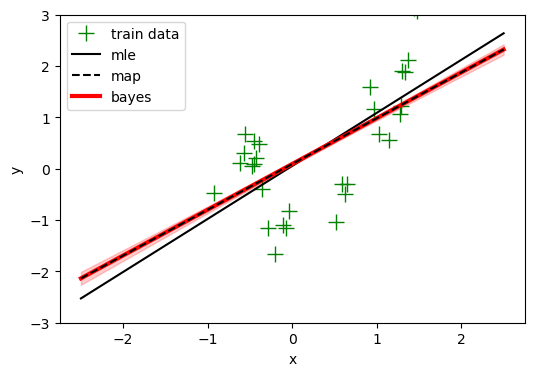

In [3]:
# load data
data = np.loadtxt("./data/ass3_data1_train.txt")
x_train, y_train = data[:, 0][:, None], data[:, 1][:, None]
data = np.loadtxt("./data/ass3_data1_valid.txt")
x_valid, y_valid = data[:, 0][:, None], data[:, 1][:, None]

# some data for visualisation
N_plot = 100
x_plot = np.linspace(-2.5, 2.5, N_plot).reshape([N_plot, 1])

# add one col to the inputs
x_train_with_bias = add_bias_col(x_train)
x_plot_with_bias = add_bias_col(x_plot)

# MLE = least squares
theta_mle = lr_mle(x_train_with_bias, y_train)
f_mle = predict_point(x_plot_with_bias, theta_mle)

# MAP = regularised least squares
alpha = 0.1
theta_map = lr_map(x_train_with_bias, y_train, alpha)
f_map = predict_point(x_plot_with_bias, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_with_bias, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_with_bias, theta_mean, theta_cov)

# plot utility
def plot(x, y, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov):
    # plot utility
    plt.figure(figsize=(6, 4))
    plt.plot(x, y, '+g', label='train data', ms=12)
    if f_mle is not None:
        plt.plot(x_plot, f_mle, '-k', label='mle')
    if f_map is not None:
        plt.plot(x_plot, f_map, '--k', label="map", zorder=10)
    if f_bayes_mean is not None:
        plt.plot(x_plot, f_bayes_mean, '-r', label="bayes", lw=3)
        f_std = np.sqrt(np.diag(f_bayes_cov))
        upper = f_bayes_mean[:, 0] + 2*f_std
        lower = f_bayes_mean[:, 0] - 2*f_std
        plt.fill_between(x_plot[:, 0], upper, lower, color='r', alpha=0.2)
    plt.legend()
    plt.xlabel('x')
    plt.ylabel('y')
    plt.ylim([-3, 3])

# plot the training data and predictions
plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 1: What makes a good regression?** ###

As can be seen from the visualisation above, the regressed line seems to be far from the datapoints. Are there any ways we can improve the regression?

**Task 1.1**

Explain why the above linear regression fails. 

The above linear regression fails because it is a simple linear model, which assumes that the relationship between the independent variable (x) and the dependent variable (y) is linear. However, the data in the plot shows that the relationship between x and y is non-linear.

**Task 1.2**

What kind of features would lead to a better result? Why? 

In order to improve the regression, we can use features that capture the non-linear relationship between x and y. For example, we could use polynomial features, such as x^2, x^3, etc. We could also use interaction features, such as x⋅y.

Polynomial features and interaction features allow the model to learn more complex relationships between the independent variables and the dependent variable. This can lead to more accurate predictions.

Additional considerations
In addition to using more complex features, we can also improve the regression by:

- Using a regularization technique, such as L1 or L2 regularization, to prevent overfitting.
- Using a cross-validation technique to tune the hyperparameters of the model.
- Using a more robust regression algorithm, such as random forests or gradient boosting machines.

**Task1.3**

Implement `featurise` function that takes raw datapoints as the input and output a reasonable design matrix $\Phi$ according to the method you mentioned in **Task 1.2**.

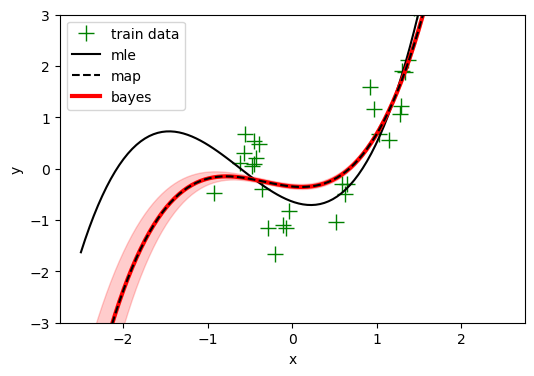

In [4]:
def featurise(x):
    features = np.hstack((np.ones((x.shape[0], 1)), x, x**2, x**3))
    return features


x_train_feat = featurise(x_train)
x_valid_feat = featurise(x_valid)
x_plot_feat = featurise(x_plot) 

# repeat but now with features
# MLE
theta_mle = lr_mle(x_train_feat, y_train)
f_mle = predict_point(x_plot_feat, theta_mle)

# MAP
alpha = 0.1
theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# exact Bayesian
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)

plot(x_train, y_train, x_plot, f_mle, f_map, f_bayes_mean, f_bayes_cov)

### **Task 2: Estimating noise variance through the marginal likelihood** ###

One commonly asked question in Bayesian linear regression is how can we define the noise level of the target. In previous questions, we set the noise variance in `lr_bayes` to be 0.01 - a fixed constant. But intuitively, after we have observed some datapoints, the noise level can actually be inferred or estimated. This tasks is designed for you to investigate the marginal likelihood (a.k.a. model evidence) and how we can use this to pick the noise variance. 

**Task 2.1**

Implement the negative log marginal likelihood, given the noise level of the likelihood, training inputs and outputs, and the prior variance. We can pick `prior_var` using the same procedure, but assume `prior_var = 0.5` for this exercise. The form of the marginal likelihood is provided in Week 7's lecture slides.

In [5]:
# 2a
def negative_log_marginal_likelihood(noise_var, x, y, prior_var=0.5):
     n = x.shape[0]
     cov= prior_var*(x @ x.T) + noise_var*np.eye(n)
     llk = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + y.T @ np.linalg.inv(cov) @ y)
     neg_llk= -1*llk

     return neg_llk



**Task 2.2**

Select the most appropriate noise level that minimises the log marginal likelihood. In practice, we can do this mimimisation by gradient descent, but for this exercise, we assume we have access to a predefined set of potential noise levels and just need to pick one.




In [6]:
# 2.2
# a predefined list
# a predefined list
potential_noise_vars = np.logspace(-4, 1.5, 50)


nll_vals = np.array([negative_log_marginal_likelihood(noise_var, x_train_feat, y_train) for noise_var in potential_noise_vars])

noise_var_estimated = potential_noise_vars[np.argmin(nll_vals)]

print(noise_var_estimated)



0.3906939937054617


**Task 2.3**

We visualise the predictions using the estimated noise variance, and compare to those when the noise is very large or very small. Based on these graphs and the negative log marginal likelihood corresponding to these noise levels, explain why finding a proper noise level of the likelihood is important. 

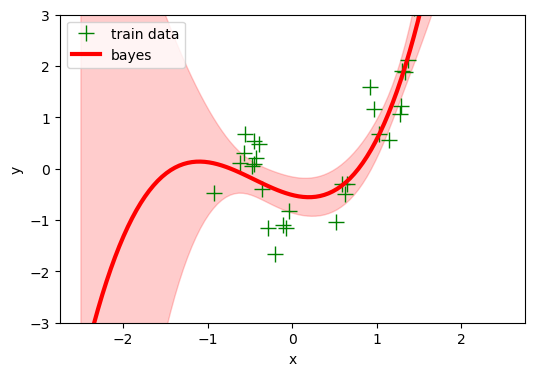

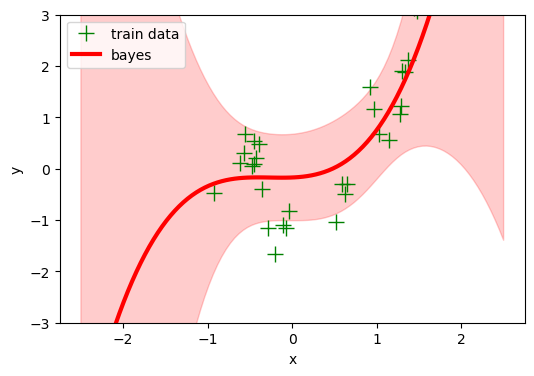

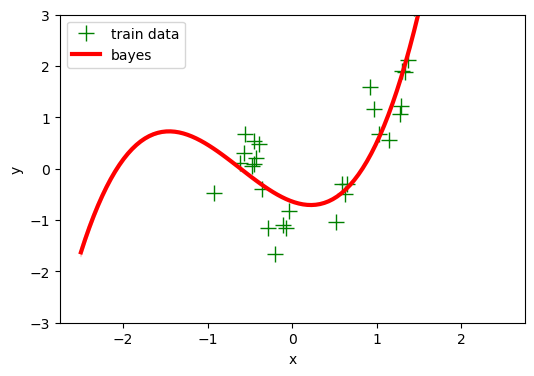

In [7]:
# fit with the estimated noise variance
N = x_train_feat.shape[0]
prior_var = 0.5
alpha = noise_var_estimated / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var_estimated)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very large noise
noise_var = 5
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

# fit with a very small noise
noise_var = 0.00001
alpha = noise_var / prior_var / N
theta_mean, theta_cov = lr_bayes(x_train_feat, y_train, alpha, noise_var)
f_bayes_mean, f_bayes_cov = predict_bayes(
    x_plot_feat, theta_mean, theta_cov)
plot(x_train, y_train, x_plot, None, None, f_bayes_mean, f_bayes_cov)

**Importance of finding a proper noise level!**

The noise level of the likelihood is important because it affects the predictions of the Bayesian linear regression model. If the noise level is too high, the model will be unable to learn the underlying relationship between the input and output variables. If the noise level is too low, the model will overfit the training data and may not generalize well to new data.

The plots show the predictions of the Bayesian linear regression model for three different noise levels:

- The estimated noise variance
- A very large noise variance
- A very small noise variance

As you can see, the model with the estimated noise variance is able to fit the training data well without overfitting. The model with the very large noise variance is unable to learn the underlying relationship between the input and output variables, and its predictions are close to a horizontal line. The model with the very small noise variance overfits the training data and its predictions are not close to the training data points, especially at the extremes of the x-axis.

The negative log marginal likelihood (NLL) is a measure of the fit of the model to the data. A lower NLL indicates a better fit.

As you can see, the model with the estimated noise variance has the lowest NLL, which indicates that it is the best fit to the data.



** Task 2.4 - Optional **

The naive implementation of the negative log marginal likelihood above would require the inverse of an N by N matrix, which is of time complexity $\Theta(N^3)$. This is computationally intractable for a large dataset (large N). Can we speed this up?

In [8]:
data = np.loadtxt("./data/ass3_data1_train_large.txt")
x_large, y_large = data[:, 0][:, None], data[:, 1][:, None]
x_large_feat = featurise(x_large)

def negative_log_marginal_likelihood_v2(noise_var, x, y, prior_var=0.5):
     n = x.shape[0]
     cov= prior_var*(x @ x.T) + noise_var*np.eye(n)
     llk = -0.5 * (n * np.log(2 * np.pi) + np.log(np.linalg.det(cov)) + y.T @ np.linalg.inv(cov) @ y)
     neg_llk= -1*llk

     return neg_llk


### **Task 3: Regularisation** ###

In machine learning, regularisation is an important technique to reduce overfitting. Regularisation also provides better generalisation in general. This task aims to show how regularisation affects the parameter estimates. 

**Task 3.1**

Implement `L1`, `L2`. Both functions take the weight $\theta$ as input, output the regularisation value and the gradient of the regularisation term (**NOT THE GRADIENT OF THE ENTIRE OBJECTIVE FUNCTION**).

In [9]:
def L1(theta):
    # L1 regularization
    reg = np.sum(np.abs(theta))
    dreg = np.sign(theta)
    return reg, dreg

def L2(theta):
    # L2 regularization
    reg = np.sum(theta**2)
    dreg = 2 * theta
    return reg, dreg


def data_fit(theta, x, y):
    diff = y - np.dot(x, theta) # N x 1
    f = np.mean(diff**2) # 1 x 1
    df = - 2 * np.dot(diff.T, x).T / x.shape[0]
    return f, df 

def objective(theta, x, y, alpha, l2=True):
    reg_func = L2 if l2 else L1
    reg, dreg = reg_func(theta)
    fit, dfit = data_fit(theta, x, y)
    obj = fit + alpha * reg
    dobj = dfit + alpha * dreg
    return obj, dobj

**Task 3.2**

We now run gradient descent and plot the predictions. Comment on the results.

0 10.540326607148831
100 0.4476385419566177
200 0.4474252105700971
300 0.44742502443388255
400 0.4474250238523166
500 0.4474250238497525
600 0.4474250238497408
700 0.44742502384974064
800 0.4474250238497407
900 0.44742502384974064
1000 0.44742502384974076
1100 0.44742502384974076
1200 0.4474250238497407
1300 0.4474250238497407
1400 0.4474250238497407
1500 0.4474250238497407
1600 0.4474250238497407
1700 0.4474250238497407
1800 0.4474250238497407
1900 0.4474250238497407
0 0.5312537419887855
100 0.5249265004488551
200 0.5244870229981777
300 0.5245747118669865
400 0.5243545421954474
500 0.5244896150982641
600 0.5248661693758173
700 0.524417389159044
800 0.5243368720154153
900 0.5244407637435343
1000 0.5245788041591049
1100 0.5249189546593072
1200 0.5242735657462732
1300 0.5243719923998602
1400 0.5244861773978534
1500 0.5246238887642181
1600 0.5245248421359999
1700 0.5243213529240043
1800 0.5244177183967222
1900 0.5245597445603832
0 0.3825339262239341
100 0.3158033869326761
200 0.3141573307

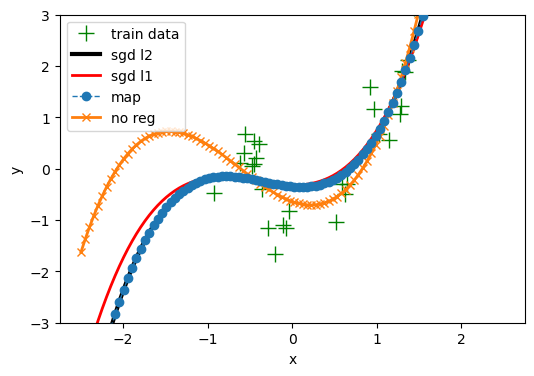

In [10]:
D = x_train_feat.shape[1]
theta_l2_sgd_init = np.random.randn(D, 1)
theta_l2_sgd = theta_l2_sgd_init

no_iters = 2000
learning_rate = 0.1
alpha = 0.1
l2 = True
for i in range(no_iters):
    obj, dobj = objective(theta_l2_sgd, x_train_feat, y_train, alpha, l2)
    theta_l2_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_l2_sgd = predict_point(x_plot_feat, theta_l2_sgd)

theta_l1_sgd = theta_l2_sgd_init
l2 = False
for i in range(no_iters):
    obj, dobj = objective(theta_l1_sgd, x_train_feat, y_train, alpha, l2)
    theta_l2_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)
f_l1_sgd = predict_point(x_plot_feat, theta_l1_sgd)

# Without any regularisation
theta_noreg_sgd = theta_l2_sgd_init
for i in range(no_iters):
    obj, dobj = objective(theta_noreg_sgd, x_train_feat, y_train, 0, l2)
    theta_noreg_sgd -= learning_rate * dobj
    if i % 100 == 0:
        print(i, obj)

f_noreg_sgd = predict_point(x_plot_feat, theta_noreg_sgd)

theta_map = lr_map(x_train_feat, y_train, alpha)
f_map = predict_point(x_plot_feat, theta_map)

# plot utility
plt.figure(figsize=(6, 4))
plt.plot(x_train, y_train, '+g', label='train data', ms=12)
plt.plot(x_plot, f_l2_sgd, '-k', lw=3, label='sgd l2')
plt.plot(x_plot, f_l1_sgd, '-r', lw=2, label='sgd l1')
plt.plot(x_plot, f_map, '--o', label="map", zorder=10, lw=1)
plt.plot(x_plot, f_noreg_sgd, '-x', label="no reg", lw=2)
plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.ylim([-3, 3])

plt.show()

The plot shows the results of the four models trained:

1. L2 regularized SGD
2. L1 regularized SGD
3. MAP
4. No regularization

- The L2 regularized SGD model performs the best, followed by the MAP model. The L1 regularized SGD model and the model without any regularization perform the worst.
This is because L2 regularization helps to prevent overfitting by shrinking the weights of the model. Overfitting occurs when the model learns the training data too well and is unable to generalize to new data.

- The L1 regularized SGD model also helps to prevent overfitting, but it does so by setting some of the weights to zero. This can lead to a sparser model, but it can also lead to a less accurate model.

- The MAP model is a Bayesian model that uses regularization to prevent overfitting. The MAP model performs well, but it trains more slowly than the L2 regularized SGD model.

- The model without any regularization is the simplest model, but it is also the most prone to overfitting.

Overall, the L2 regularized SGD model is a good choice for regularizing linear regression models. It is able to prevent overfitting and train quickly.

Here are some additional comments on the plot:

- The L2 regularized SGD model and the MAP model are able to fit the training data well without overfitting. This is evident from the fact that their predictions are close to the training data points.
- The L1 regularized SGD model and the model without any regularization overfit the training data. This is evident from the fact that their predictions are not close to the training data points, especially at the extremes of the x-axis.
